In [1]:
from scipy import io as scipy_io
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.utils import io as ipy_io
import sys
import re
import lidar_sim_class_declarations
import pickle
from datetime import datetime


data_path = '/data/allen/Lidar Simulation/lidarmodeling_202404'
output_root_path = '/data/shared/src/STV/simscenes/LidarSimulation/figs/veg_input'
gort_output = '/data/shared/src/STV/simscenes/LidarSimulation/Gort/OrigGORTInput/'
object_path = '/data/shared/src/STV/simscenes/LidarSimulation/object_data/'

data_version = '008'

redwood_file = 'rw_alltreeinfo.mat'
guiana_file = 'fg_alltreeinfo.mat'

redwood_matlab_filepath = os.path.normpath(os.path.join(data_path, 'RW' + data_version, redwood_file))
guiana_matlab_filepath = os.path.normpath(os.path.join(data_path, 'FG' + data_version, guiana_file))

redwood_mat_data = scipy_io.loadmat(redwood_matlab_filepath)
guiana_mat_data = scipy_io.loadmat(guiana_matlab_filepath)

radius = 33.3 / 2

# Leaf Density ratio
redwood_leaf_density_ratio = 2500  # Leaves per m3
guiana_leaf_density_ratio = 8750  # Leaves per m3  Original 8750 number
guiana_leaf_density_ratio_div10 = 875  # Leaves per m3  Original 8750 number divided by 10 for more realistic density per m3
guiana_leaf_density_ratio_div30 = 291.5  # Leaves per m3  Original 8750 number divided by 30 for more realistic density per m3

branch_scale_orig = 1
branch_scale_10th = 0.1

In [2]:
def get_date_subfolder():
    current_date = datetime.now()
    return current_date.strftime('%Y_%m_%d')

def circle_intersection_percentage(x1, y1, r1, x2, y2, r2):
    # Calculate the area of the first circle
    area1 = math.pi * r1**2
    
    # Calculate the distance between the centers of the circles
    d = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    # Check if the circles are separate or one is completely inside the other
    if d >= r1 + r2:
        # Circles are separate, no intersection
        return 0
    elif d <= abs(r1 - r2) and r1 >= r2:
        # Circle 2 is completely inside circle 1, intersection area is area of circle 2
        return math.pi * r2**2 / area1 * 100
    elif d <= abs(r1 - r2) and r1 < r2:
        # Circle 1 is completely inside circle 2, intersection area is area of circle 1
        return 100
    else:
        # Calculate the intersection area using the formula for the area of a circular segment
        A = r1**2 * math.acos((d**2 + r1**2 - r2**2) / (2 * d * r1)) + r2**2 * math.acos((d**2 + r2**2 - r1**2) / (2 * d * r2)) - 0.5 * math.sqrt((-d + r1 + r2) * (d + r1 - r2) * (d - r1 + r2) * (d + r1 + r2))
        return A / area1 * 100
    
def load_matlab(region):
    if region == 'redwood':
        tree_elements = redwood_mat_data['tree'][0]
        x_values = redwood_mat_data['tree_x'][0]
        y_values = redwood_mat_data['tree_y'][0]
    elif region == 'guiana':
        tree_elements = guiana_mat_data['tree'][0]
        x_values = guiana_mat_data['tree_x'][0]
        y_values = guiana_mat_data['tree_y'][0]
    else:
        raise ValueError("Invalid region. Please specify either 'redwood' or 'guiana'.")

    return tree_elements, x_values, y_values

# This function creates and returns a list of Circle objects and assigns their name, and x_coord, y_coord
def create_circle_data(radius):

    circles_grid = []

    # Check each circle in the 3x3 grid
    for i in range(3, 0, -1):
        for j in range(1, 4):
            # Calculate the center of the current circle
            center_x = (j - 2) * 2 * radius
            center_y = (i - 2) * 2 * radius

            # Create the circle object with a unique name
            circle_name = f"Circle({i}, {j})"
            circle = lidar_sim_class_declarations.Circle(circle_name)

            # Assign the calculated coordinates to the circle
            circle.x_coord = center_x
            circle.y_coord = center_y
            circle.row = i
            circle.column = j

            # Append the circle to the grid list
            circles_grid.append(circle)

    return circles_grid

def calc_basic_tree_info(tree_index, tree_element, tree, redwood_x_values, redwood_y_values, site, leaf_density, branch_scale):

    # Extract crown base height, d1, d2, d3 value from tree data
    base = tree_element[0][0][0][0][0][0]
    d1 = tree_element[0][0][0][1][0][0]
    d2 = tree_element[0][0][0][2][0][0]
    d3 = tree_element[0][0][0][3][0][0]

    deciduous_volume = (4/3) * math.pi * d2**2 * d1
    pine_001_volume = (math.pi * d2**2 * d3) + deciduous_volume/2
    pine_002_volume = (math.pi * d2**2 * d3) + (1/3 * math.pi * d2**2 * d1)

    if (site == "redwood"):
        # Calculate the volume of the tree spheroid
        crown_volume = deciduous_volume
        # Calculate the Crown Center Height for each tree in the circle
        crown_center_height = base + (d3 / 2)
        # Calculate the Crown Base height
        crown_base_height = crown_center_height - d1
    elif (site == "guiana"):
        # Calculate the volume of the tree spheroid
        crown_volume = deciduous_volume
        # Calculate the Crown Center Height for each tree in the circle
        crown_center_height = base + (d3 / 2)
        # Calculate the Crown Base height
        crown_base_height = crown_center_height - d1

    # Calculate the Tree Height for each tree in the circle
    tree_height = base + d1 + (d3 / 2)
    # Calculate total ground area, just the area of circle with crown_radius d1
    total_tree_ground_areas = math.pi * d2**2

    # Extract leaf number, leaf width, tree leaf, calculate leaf area, then total leaf area
    single_leaf_length = tree_element[5][0][0][1][0][0]
    single_leaf_width = tree_element[5][0][0][2][0][0]
    single_leaf_area = single_leaf_length * single_leaf_width

    # Add basic info to each tree
    tree.tree_index = tree_index
    tree.crown_base = base
    tree.crown_d1 = d1
    tree.crown_d2 = d2
    tree.crown_d3 = d3

    tree.crown_volume = crown_volume
    tree.crown_center_height = crown_center_height
    tree.crown_base_height = crown_base_height
    tree.tree_height = tree_height
    tree.total_tree_ground_area = total_tree_ground_areas
    tree.leaf_density = leaf_density
    tree.branch_scale = branch_scale

    total_branch_area = calc_basic_branch_info(tree_element)

    if (site == "redwood"):
        single_leaf_area *= 2  # redwoods:  assuming d2 or d3 are radius, so 2 * radius * length = area of rectangle cross section of leaf
    # if guiana:  assuming d1 is length, d2 is width, and d3 is thickness of leaf, width x length = area of leaf
    
        total_branch_area *= branch_scale

    total_leaf_area = single_leaf_area * leaf_density * crown_volume
    tree.single_leaf_area = single_leaf_area
    tree.total_leaf_area = total_leaf_area

    tree.total_tree_branch_area = total_branch_area

    tree_total_canopy_veg_areas = total_leaf_area + total_branch_area
    tree.total_tree_canopy_veg_area = tree_total_canopy_veg_areas

    # Assign x and y coordinates
    tree.x_coord = redwood_x_values[tree_index - 1]  # Adjusting for 1-based indexing
    tree.y_coord = redwood_y_values[tree_index - 1]

# This function gets the branch info from tree_element list and calculates and returns the total branch area
def calc_basic_branch_info(tree_element):

    # Initial values for total primary, secondary, and tertiary branch areas
    total_prim_branch_area = 0
    total_sec_branch_area = 0
    total_tert_branch_area = 0

    # For each tree, iterate through each primary branch array to get the total primary branch area
    for prim_branch_index in range(len(tree_element[2][0][0][0][0])):
        prim_branch_length = tree_element[2][0][0][0][0][prim_branch_index]
        prim_branch_radius = tree_element[2][0][0][1][0][prim_branch_index]
        prim_branch_area = 2 * prim_branch_radius * prim_branch_length
        total_prim_branch_area = total_prim_branch_area + prim_branch_area

    # for each tree, iterate through each secondary branch array to get the total secondary branch area
    for sec_branch_index in range(len(tree_element[3][0][0][0][0])):
        sec_branch_length = tree_element[3][0][0][0][0][sec_branch_index]
        sec_branch_radius = tree_element[3][0][0][1][0][sec_branch_index]
        sec_branch_area = 2 * sec_branch_radius * sec_branch_length
        total_sec_branch_area = total_sec_branch_area + sec_branch_area    
    
    # for each tree, iterate through each tertiary branch array to get the total tertiary branch area
    for tert_branch_index in range(len(tree_element[4][0][0][0][0])):
        tert_branch_length = tree_element[4][0][0][0][0][tert_branch_index]
        tert_branch_radius = tree_element[4][0][0][1][0][tert_branch_index]
        tert_branch_area = 2 * tert_branch_radius * tert_branch_length
        total_tert_branch_area = total_tert_branch_area + tert_branch_area

    total_branch_area = (total_prim_branch_area + total_sec_branch_area + total_tert_branch_area) # adjusted for realism

    return(total_branch_area)

# This function attempts to find a single tree object in the list of circle objects
def find_tree_in_circle(tree, circle_objects):

    # Flag to indicate whether the point falls within a circle
    circle_within_grid = False

    # Iterates through list of circle objects
    for circle in circle_objects:

        # Calculate the distance of the tree x,y coord from the center x,y coord of the Circle
        dist = math.sqrt((circle.x_coord - tree.x_coord)**2 + (circle.y_coord - tree.y_coord)**2)

        # Check if the distance is less than or equal to the radius
        if dist <= radius + tree.crown_d2:
            print(f'Tree {tree.tree_index} at {tree.x_coord}, {tree.y_coord} found in: Circle({circle.row}, {circle.column})')

            # Calculate the volume of the intersection between the tree and the circle
            intersection_percentage = circle_intersection_percentage(tree.x_coord, tree.y_coord, tree.crown_d2, circle.x_coord, circle.y_coord, radius) / 100
            intersection_volume = tree.crown_volume * intersection_percentage
            print(f'\tTree {tree.tree_index} crown volume is: {tree.crown_volume}')
            print(f'\tTree {tree.tree_index} intersection percentage with Circle ({circle.row}, {circle.column}) is: {intersection_percentage}')
            print(f'\tApprox. Tree {tree.tree_index} intersection volume with Circle ({circle.row}, {circle.column} is: {intersection_volume}\n')


            # Add tree index, crown percentage and intersection volume to circle object
            circle.tree_indices = np.append(circle.tree_indices, tree.tree_index)
            circle.crown_percentages = np.append(circle.crown_percentages, intersection_percentage)
            circle.crown_vol_in_circle = np.append(circle.crown_vol_in_circle, intersection_volume)

            circle_within_grid = True  # Set flag to True

    # If the tree is not found within any circle, print the message
    if not circle_within_grid:
        print(f'Tree {tree.tree_index} at {tree.x_coord}, {tree.y_coord} with radius {tree.crown_d2} not found within any grid circle!\n')

def plot_trees(tree_objects, circle_objects, output_path, region):
    output_file = os.path.join(output_path, region + '_trees_plots.png')
    # Set the figure size
    plt.figure(figsize=(20, 20))

    plt.rcParams['axes.titlesize'] = 36
    plt.rcParams['axes.labelsize'] = 15
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 15

    # Create a scatter plot for each tree
    for index, tree in enumerate(tree_objects, start=1):
        x, y = tree.x_coord, tree.y_coord
        d2 = tree.crown_d2  # Assuming tree has an attribute d2 for crown diameter
        plt.scatter(x, y, color='black', marker='o')  # Black dot for tree
        
        # Draw green circle around the tree with radius equal to d2
        circle = plt.Circle((x, y), d2, color='green', fill=False, linestyle='--', linewidth=1.5)
        plt.gca().add_artist(circle)

        # Add text label for the tree index slightly below the point
        plt.text(x, y - 1.5, str(index), ha='center', va='center', fontsize=12)  # Adjust fontsize and offset as needed

    # Plot the circles and label them
    for circle in circle_objects:
        center_x, center_y = circle.x_coord, circle.y_coord
        circle_artist = plt.Circle((center_x, center_y), radius, color='red', fill=False)
        plt.gca().add_artist(circle_artist)
        plt.text(center_x, center_y, f'({circle.row}, {circle.column})', ha='center', va='center', fontsize=12, color='red')  # Adjust fontsize as needed

    # Add labels, title, etc. if required
    plt.xlabel('X')
    plt.ylabel('Y')
    if region == 'redwood':
        plt.title('Scatter Plot of Trees with Circle Plots \n(with 33.3m diameter) in California Redwoods')
    elif region == 'guiana':
        plt.title('Scatter Plot of Trees with Circle Plots \n(with 33.3m diameter) in French Guiana')

    # Set equal aspect ratio
    plt.gca().set_aspect('equal', adjustable='box')

    # Save the plot
    plt.savefig(output_file)
    
    print(f"{region} plot image saved to: {output_file}")

    # Show the plot
    plt.show()

def save_objects_to_file(objects_list, filename, obj_path):
    # Create the subfolder if it doesn't exist
    os.makedirs(obj_path, exist_ok=True)
    filename = os.path.join(obj_path, filename)
        
    # Save the objects to file
    with open(filename, 'wb') as f:
        pickle.dump(objects_list, f)

def load_objects_from_file(filename, subfolder=""):
    # Adjust the filename to include the subfolder
    if subfolder:
        filename = os.path.join(subfolder, filename)
        
    # Load the objects from file
    with open(filename, 'rb') as f:
        objects_list = pickle.load(f)
    
    return objects_list

stdout redirected to: /data/shared/src/STV/simscenes/LidarSimulation/figs/veg_input/2024_10_11/redwood_output/redwood_tree_search_output.txt

tree_index: 1
x_coord: -58.22
y_coord: 39.89
crown_base: 6.53279
crown_d1: 4.75503
crown_d2: 2.70483
crown_d3: 9.46251
crown_base_height: 6.509015
crown_center_height: 11.264045
tree_height: 16.019075
crown_volume: 145.72089163029327
single_leaf_area: 6e-05
total_leaf_area: 21.858133744543988
total_tree_branch_area: 509.1073367371114
total_tree_stem_area: 0
total_tree_ground_area: 22.984222754161376
total_tree_canopy_veg_area: 530.9654704816554
leaf_density: 2500
branch_scale: 1

tree_index: 2
x_coord: -58.43
y_coord: 32.12
crown_base: 7.02676
crown_d1: 5.83397
crown_d2: 3.09267
crown_d3: 11.6096
crown_base_height: 6.99759
crown_center_height: 12.83156
tree_height: 18.66553
crown_volume: 233.732962642793
single_leaf_area: 6e-05
total_leaf_area: 35.05994439641895
total_tree_branch_area: 808.3898341710008
total_tree_stem_area: 0
total_tree_ground_a

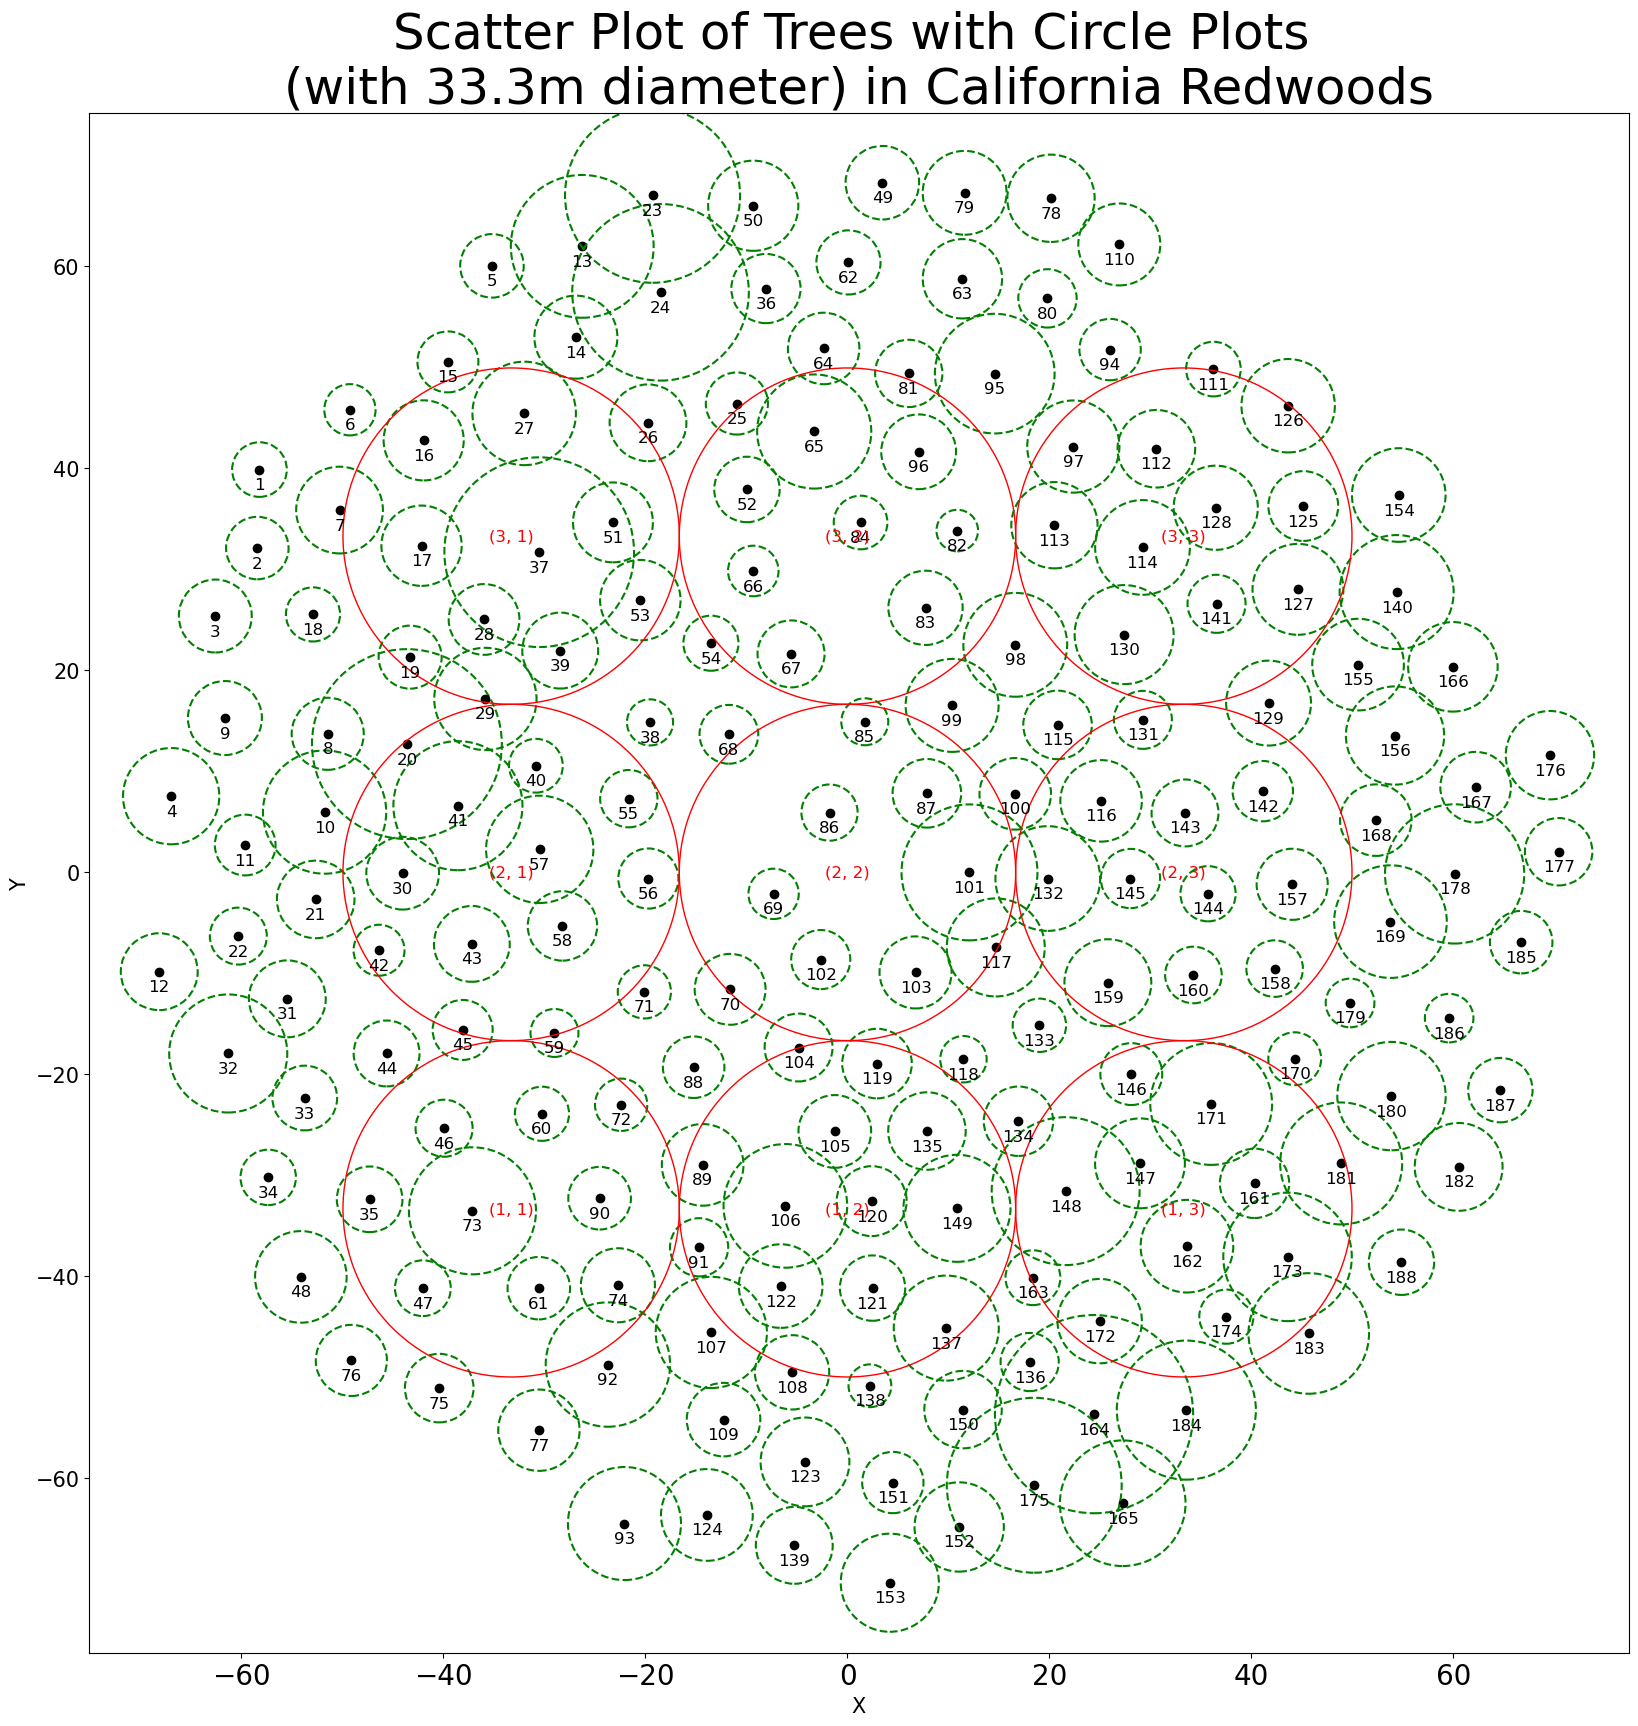

In [3]:
### This block assigns California Redwoods tree and circle data and plots and outputs the overhead visual representation of the site

date_subfolder = get_date_subfolder()
redwood_subpath = "redwood_output"
guiana_subpath = "guiana_output"
# Redirecting stdout to a text file
redwood_output_path = os.path.normpath(os.path.join(output_root_path, date_subfolder, redwood_subpath))
guiana_output_path = os.path.normpath(os.path.join(output_root_path, date_subfolder, guiana_subpath))
output_file = os.path.join(redwood_output_path, 'redwood_tree_search_output.txt')

# Create the output directory if it doesn't exist
if not os.path.exists(redwood_output_path):
    os.makedirs(redwood_output_path)

# Specify region to California Redwoods
region = 'redwood'

# Initialize list of Tree objects
redwood_tree_objects_branch_orig = []
redwood_tree_objects_branch_origB10th = []

# Initilizes list of Circle objects for Redwood site.  Circles are assigned names and x_coord and y_coord
redwood_circle_objects_orig = create_circle_data(radius)
redwood_circle_objects_origB10th = create_circle_data(radius)

# Use %%capture to capture output
with ipy_io.capture_output() as captured_output:

    # Load matlab data into lists
    redwood_tree_elements, redwood_x_values, redwood_y_values = load_matlab(region)
    # Get total tree count
    total_trees = len(redwood_x_values)

    # Loop interates through all trees
    for tree_index, (x, y, tree_element) in enumerate(zip(redwood_x_values, redwood_y_values, redwood_tree_elements), start=1):

        # Declare Tree object
        tree_orig = lidar_sim_class_declarations.Tree(tree_index)
        tree_origB10th = lidar_sim_class_declarations.Tree(tree_index)
        print(f"Processing tree {tree_index} of {total_trees}")

        # Calls functions to assign basic tree info, then find tree in any of the cirlces
        calc_basic_tree_info(tree_index, tree_element, tree_orig, redwood_x_values, redwood_y_values, "redwood", redwood_leaf_density_ratio, branch_scale_orig)
        calc_basic_tree_info(tree_index, tree_element, tree_origB10th, redwood_x_values, redwood_y_values, "redwood", redwood_leaf_density_ratio, branch_scale_10th)
        find_tree_in_circle(tree_orig, redwood_circle_objects_orig)
        find_tree_in_circle(tree_origB10th, redwood_circle_objects_origB10th)

        # Append the Tree object to the list
        redwood_tree_objects_branch_orig.append(tree_orig)
        redwood_tree_objects_branch_origB10th.append(tree_origB10th)

# Writes captured output to file
with open(output_file, "w") as file:
    file.write(captured_output.stdout)

print(f"stdout redirected to: {output_file}")

for tree in redwood_tree_objects_branch_orig:
    print()
    tree.print_attributes()

for tree in redwood_tree_objects_branch_origB10th:
    print()
    tree.print_attributes()

# Plot trees and circles for French Guiana
plot_trees(redwood_tree_objects_branch_orig, redwood_circle_objects_orig, redwood_output_path, region)

In [4]:
def get_circle_derived_values(circle, trees, leaf_density):

    # Initialize lists to store values for the current circle
    d1_values = [trees[tree_index - 1].crown_d1 for tree_index in circle.tree_indices]
    d2_values = [trees[tree_index - 1].crown_d2 for tree_index in circle.tree_indices]
    single_leaf_areas = [trees[tree_index - 1].single_leaf_area for tree_index in circle.tree_indices]
    tree_branch_areas = [trees[tree_index - 1].total_tree_branch_area for tree_index in circle.tree_indices]
    crown_volumes = [trees[tree_index - 1].crown_volume for tree_index in circle.tree_indices]
    crown_center_height = [trees[tree_index - 1].crown_center_height for tree_index in circle.tree_indices]
    tree_heights = [trees[tree_index - 1].tree_height for tree_index in circle.tree_indices]
    crown_volumes_in_circle = circle.crown_vol_in_circle
    total_tree_canopy_veg_area = [trees[tree_index - 1].total_tree_canopy_veg_area for tree_index in circle.tree_indices]


    # Calculate number of trees found in the circle
    crown_percentages = circle.crown_percentages
    tree_percent_total = np.sum(crown_percentages)
    # Calculate area of the circle
    pixel_area = math.pi * (radius ** 2)
    # Calculate tree density
    tree_density = tree_percent_total / pixel_area

    # Calculate leaf, branch and total canopy vegetation areas, added adjusted areas with partial crown percentages
    adj_leaf_areas = [single_leaf_area * leaf_density * adj_crown_volumes for single_leaf_area, adj_crown_volumes in zip(single_leaf_areas, crown_volumes_in_circle)]
    adj_branch_areas = [branch_area * crown_percentage for branch_area, crown_percentage in zip(tree_branch_areas, crown_percentages)]
    total_adj_tree_canopy_veg_area = [adj_leaf_area + adj_branch_area for adj_leaf_area, adj_branch_area in zip(adj_leaf_areas, adj_branch_areas)]

    # Calculate mean and standard deviation of 'd1' values
    mean_d1 = np.mean(d1_values)
    std_d1 = np.std(d1_values)
    mean_d2 = np.mean(d2_values)
    std_d2 = np.std(d2_values)
    mean_crown_center_height = np.mean(crown_center_height)
    std_crown_center_height = np.std(crown_center_height)
    mean_tree_height = np.mean(tree_heights)
    std_tree_height = np.std(tree_heights)
    mean_crown_volume = np.mean(crown_volumes_in_circle)
    std_crown_volume = np.std(crown_volumes_in_circle)
    total_crown_volume = np.sum(crown_volumes)
    total_pixel_veg_area = np.sum(total_adj_tree_canopy_veg_area)
    total_leaf_veg_area = np.sum(adj_leaf_areas)
    adj_total_crown_volume = np.sum(crown_volumes_in_circle)

    # Calculate h1 and h2 each circle
    h1 = mean_crown_center_height - (1 * std_crown_center_height)
    h2 = mean_crown_center_height + (3 * std_crown_center_height)

    LAI = total_pixel_veg_area/pixel_area
    LAI_without_branch = total_leaf_veg_area/pixel_area
    Fa_with_branch = LAI/(adj_total_crown_volume / pixel_area)
    Fa_without_branch = LAI_without_branch/(adj_total_crown_volume / pixel_area)

    # Update circle with calculated values
    circle.tree_percent_total = tree_percent_total
    circle.tree_density = tree_density
    circle.mean_crown_d1 = mean_d1
    circle.std_crown_d1 = std_d1
    circle.mean_crown_d2 = mean_d2
    circle.std_crown_d2 = std_d2
    circle.mean_crown_center_height = mean_crown_center_height
    circle.std_crown_center_height = std_crown_center_height
    circle.tree_heights = np.array(tree_heights)
    circle.mean_tree_height = mean_tree_height
    circle.std_tree_height = std_tree_height
    circle.mean_crown_volume = mean_crown_volume
    circle.std_crown_volume = std_crown_volume
    circle.total_crown_volume = total_crown_volume
    circle.adj_crown_volume = adj_total_crown_volume
    circle.single_leaf_areas = np.array(single_leaf_areas)
    circle.adj_leaf_areas = np.array(adj_leaf_areas)
    circle.adj_branch_areas = np.array(adj_branch_areas)
    circle.total_tree_canopy_veg_area = np.array(total_adj_tree_canopy_veg_area)
    circle.pixel_area = pixel_area
    circle.total_vegetation_area_per_pixel = total_pixel_veg_area
    circle.total_leaf_veg_area = total_leaf_veg_area
    circle.LAI_with_branch = LAI
    circle.LAI_without_branch = LAI_without_branch
    circle.h1 = h1
    circle.h2 = h2
    circle.Fa_b = Fa_with_branch
    circle.Fa = Fa_without_branch

def output_derived_data(circle):
    # Print results
    print(f"Total Trees found in {circle.circle_name}: {circle.tree_percent_total}")
    print(f"Tree Indices: {circle.tree_indices}")
    print(f"Tree Density: {circle.tree_density}")
    print(f"Mean Vertical Crown Radius: {circle.mean_crown_d1}, STD Vertical Crown Radius: {circle.std_crown_d1}")
    print(f"Mean Horizontal Crown Radius: {circle.mean_crown_d2}, STD Horizontal Crown Radius: {circle.std_crown_d2}")
    print(f"Mean Crown Center Height: {circle.mean_crown_center_height}, STD Crown Center Height: {circle.std_crown_center_height}")
    print(f"Tree Heights: {circle.tree_heights}")
    print(f"Mean Tree Height: {circle.mean_tree_height}, STD Tree Height: {circle.std_tree_height}")
    print(f"Crown Volume found in Circle: {circle.circle_name}: {circle.crown_vol_in_circle}")
    print(f"Mean Crown Volume: {circle.mean_crown_volume}, STD Crown Volume: {circle.std_crown_volume}")
    print(f"Total Crown Volume: {circle.total_crown_volume}")
    print(f"Adjusted Partial Crown Volumes: {circle.adj_crown_volume}")
    print(f"h1: {circle.h1}, h2: {circle.h2}")
    print(f"Tree Single Leaf Areas: {circle.single_leaf_areas}")
    print(f"Tree Total Leaf Areas: {circle.adj_leaf_areas}")
    print(f"Tree Branch Areas: {circle.adj_branch_areas}")
    print(f"Total Vegetation Areas per tree: {circle.total_tree_canopy_veg_area}")
    print(f"Total Vegetation Areas per Pixel: {circle.total_vegetation_area_per_pixel}")
    print(f"Total Vegetation Areas per Pixel without branch areas: {circle.total_leaf_veg_area}")
    print(f"Circle Pixel area: {circle.pixel_area}")
    print(f"LAI Index per Unit Area: {circle.LAI_with_branch}")
    print(f"LAI Index per Unit Area without branch areas: {circle.LAI_without_branch}")
    print(f"Fa per Unit Area: {circle.Fa_b}")
    print(f"Fa per Unit Area without branch areas: {circle.Fa}")
    print()

In [5]:
output_file_original = os.path.join(redwood_output_path, 'redwood_circle_derived_orig.txt')
output_file_origB10th = os.path.join(redwood_output_path, 'redwood_circle_derived_origB10th.txt')

# Use %%capture to capture output
with ipy_io.capture_output() as captured_output:

    print("California Redwood Results:\n")

    tree_sum = 0

    for circle in redwood_circle_objects_orig:

        get_circle_derived_values(circle, redwood_tree_objects_branch_orig, redwood_leaf_density_ratio)
        output_derived_data(circle)

    tree_sum = 0
    for circle in redwood_circle_objects_orig:

        circle_name = circle.circle_name
        tree_indices = circle.tree_indices
        crown_percentages = circle.crown_percentages
        tree_percent_total = circle.tree_percent_total
        tree_sum += tree_percent_total

        print(f"Total Trees found in {circle_name}: {tree_percent_total}")
        print(f"Tree indices: {tree_indices}")
        print("Percent of tree crown in circle: " + ", ".join([f"{percentage:.4f}" for percentage in crown_percentages]))
        print()  # Print a blank line for separation

    print(f"Total number of trees found in all circles: {tree_sum} out of {len(redwood_tree_objects_branch_orig)}")

with open(output_file_original, "w") as file:
    file.write(captured_output.stdout)


# Use %%capture to capture output
with ipy_io.capture_output() as captured_output:

    print("California Redwood Results:\n")

    tree_sum = 0

    for circle in redwood_circle_objects_origB10th:

        get_circle_derived_values(circle, redwood_tree_objects_branch_origB10th, redwood_leaf_density_ratio)
        output_derived_data(circle)

    tree_sum = 0
    for circle in redwood_circle_objects_origB10th:

        circle_name = circle.circle_name
        tree_indices = circle.tree_indices
        crown_percentages = circle.crown_percentages
        tree_percent_total = circle.tree_percent_total
        tree_sum += tree_percent_total

        print(f"Total Trees found in {circle_name}: {tree_percent_total}")
        print(f"Tree indices: {tree_indices}")
        print("Percent of tree crown in circle: " + ", ".join([f"{percentage:.4f}" for percentage in crown_percentages]))
        print()  # Print a blank line for separation

    print(f"Total number of trees found in all circles: {tree_sum} out of {len(redwood_tree_objects_branch_origB10th)}")

with open(output_file_origB10th, "w") as file:
    file.write(captured_output.stdout)

In [6]:
for circle in redwood_circle_objects_orig:
    circle.print_attributes()

circle_name: Circle(3, 1)
x_coord: -33.300000
y_coord: 33.300000
row: 3
column: 1
tree_indices: [ 7 14 15 16 17 19 20 26 27 28 29 37 39 51 53]
crown_vol_in_circle: [ 248.26696059    0.32523409   34.91988234  495.41275132  504.32625546
  171.29795503  401.21370334  150.14615303 1002.6985605   337.14874305
  515.6410405  4884.29356445  441.46961146  504.25205435  410.04984457]
crown_percentages: [0.39477425 0.00057048 0.15108792 0.99471357 1.         0.69163379
 0.08520866 0.32263391 0.96574886 1.         0.50879085 1.
 1.         1.         0.84088965]
tree_heights: [25.94412 26.03559 19.14973 23.71524 23.94105 19.64225 41.67815 23.85574
 29.03983 20.77117 29.2986  42.18075 23.12683 25.44789 23.62493]
single_leaf_areas: [0.00006 0.00006 0.00006 0.00006 0.00006 0.00006 0.00006 0.00006 0.00006
 0.00006 0.00006 0.00006 0.00006 0.00006 0.00006]
adj_branch_areas: [  834.30602445     1.13137509   126.25371276  1658.47065431
  1698.99037967   602.45436635  1353.60632675   529.65886593
  3322.2

French Guiana Trees:

tree_index: 1
x_coord: 55.95
y_coord: -20.39
crown_base: 10.6903
crown_d1: 3.13846
crown_d2: 1.41868
crown_d3: 6.24553
crown_base_height: 10.674605
crown_center_height: 13.813065
tree_height: 16.951525
crown_volume: 26.459041027951855
single_leaf_area: 0.01161
total_leaf_area: 2687.9078304270593
total_tree_branch_area: 24.280263975442065
total_tree_stem_area: 0
total_tree_ground_area: 6.3229356980697204
total_tree_canopy_veg_area: 2712.1880944025015
leaf_density: 8750
branch_scale: 1

tree_index: 2
x_coord: -51.72
y_coord: 33.54
crown_base: 8.87645
crown_d1: 2.82546
crown_d2: 1.16317
crown_d3: 5.62266
crown_base_height: 8.86232
crown_center_height: 11.68778
tree_height: 14.51324
crown_volume: 16.012684903254968
single_leaf_area: 0.01161
total_leaf_area: 1626.6886276094142
total_tree_branch_area: 15.379986075110526
total_tree_stem_area: 0
total_tree_ground_area: 4.250463173232403
total_tree_canopy_veg_area: 1642.0686136845247
leaf_density: 8750
branch_scale: 1

tre

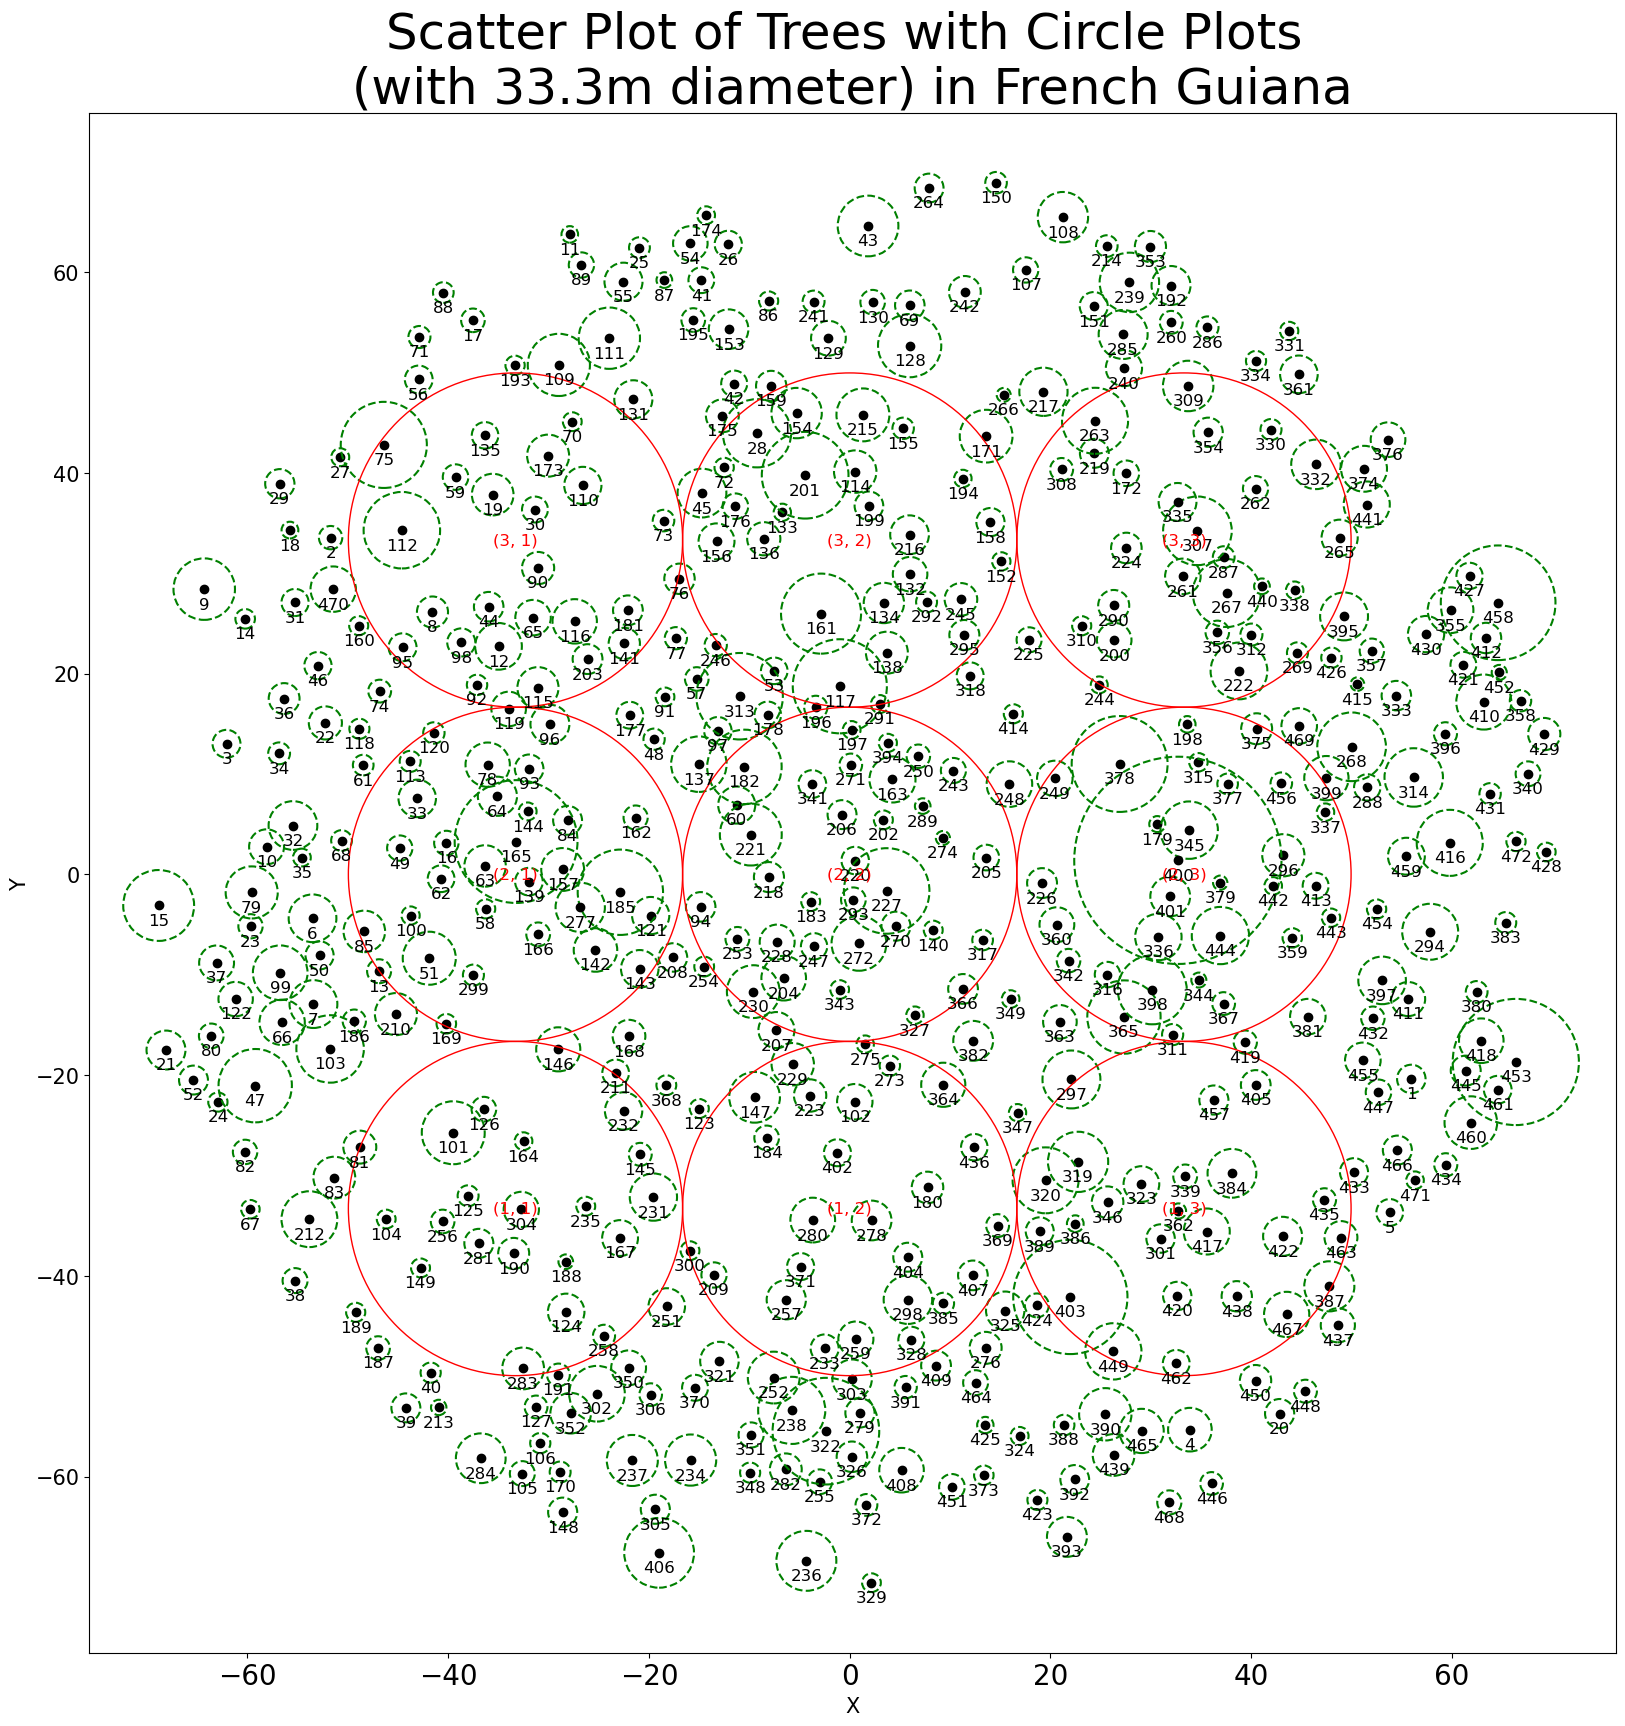

In [7]:
### This block assigns French Guiana tree and circle data and plots and outputs the overhead visual representation of the site

# Redirecting stdout to a text file
output_file = os.path.join(guiana_output_path, 'guiana_tree_search_output.txt')

# Create the output directory if it doesn't exist
if not os.path.exists(guiana_output_path):
    os.makedirs(guiana_output_path)

# Specify region to French Guiana
region = 'guiana'

# Initialize list of Tree objects for French Guiana
guiana_tree_objects_leaf_orig = []
guiana_tree_objects_leaf_div10 = []
guiana_tree_objects_leaf_div30 = []

# Initializes list of Circle objects for French Guiana site. Circles are assigned names and x_coord and y_coord
guiana_circle_objects_leaf_orig = create_circle_data(radius)
guiana_circle_objects_leaf_div10 = create_circle_data(radius)
guiana_circle_objects_leaf_div30 = create_circle_data(radius)

# Use %%capture to capture output
with ipy_io.capture_output() as captured_output:

    # Load matlab data into lists for French Guiana
    guiana_tree_elements, guiana_x_values, guiana_y_values = load_matlab(region)
    branch_scale_orig = 1
    
    # Get total tree count for French Guiana
    total_trees = len(guiana_x_values)

    # Loop interates through all trees in French Guiana
    for tree_index, (x, y, tree_element) in enumerate(zip(guiana_x_values, guiana_y_values, guiana_tree_elements), start=1):

        # Declare Tree object for French Guiana
        tree_leaf_orig = lidar_sim_class_declarations.Tree(tree_index)
        tree_leaf_div10 = lidar_sim_class_declarations.Tree(tree_index)
        tree_leaf_div30 = lidar_sim_class_declarations.Tree(tree_index)
        print(f"Processing tree {tree_index} of {total_trees}")

        # Calls functions to assign basic tree info, then find tree in any of the circles in French Guiana
        calc_basic_tree_info(tree_index, tree_element, tree_leaf_orig, guiana_x_values, guiana_y_values, "guiana", guiana_leaf_density_ratio, branch_scale_orig)
        calc_basic_tree_info(tree_index, tree_element, tree_leaf_div10, guiana_x_values, guiana_y_values, "guiana", guiana_leaf_density_ratio_div10, branch_scale_orig)
        calc_basic_tree_info(tree_index, tree_element, tree_leaf_div30, guiana_x_values, guiana_y_values, "guiana", guiana_leaf_density_ratio_div30, branch_scale_orig)
        find_tree_in_circle(tree_leaf_orig, guiana_circle_objects_leaf_orig)
        find_tree_in_circle(tree_leaf_div10, guiana_circle_objects_leaf_div10)
        find_tree_in_circle(tree_leaf_div30, guiana_circle_objects_leaf_div30)

        # Append the Tree object to the list for French Guiana
        guiana_tree_objects_leaf_orig.append(tree_leaf_orig)
        guiana_tree_objects_leaf_div10.append(tree_leaf_div10)
        guiana_tree_objects_leaf_div30.append(tree_leaf_div30)

# Writes captured output to file for French Guiana
with open(output_file, "w") as file:
    file.write(captured_output.stdout)

print("French Guiana Trees:")

# Print attributes of each tree in French Guiana
for tree in guiana_tree_objects_leaf_orig:
    print()
    tree.print_attributes()

for tree in guiana_tree_objects_leaf_div10:
    print()
    tree.print_attributes()

for tree in guiana_tree_objects_leaf_div30:
    print()
    tree.print_attributes()

print()

# Plot trees and circles for French Guiana
plot_trees(guiana_tree_objects_leaf_orig, guiana_circle_objects_leaf_orig, guiana_output_path, region)

In [8]:
# Redirecting stdout to a text file
output_file_leaf_original = os.path.join(guiana_output_path, 'guiana_circle_derived_leaf_orig.txt')
output_file_leaf_div10 = os.path.join(guiana_output_path, 'guiana_circle_derived_leaf_div10.txt')
output_file_leaf_div30 = os.path.join(guiana_output_path, 'guiana_circle_derived_leaf_div30.txt')

# Use %%capture to capture output
with ipy_io.capture_output() as captured_output:

    print("French Guiana Results:\n")

    tree_sum = 0

    # Calculate and output derived values for each circle in French Guiana
    for circle in guiana_circle_objects_leaf_orig:
        get_circle_derived_values(circle, guiana_tree_objects_leaf_orig, guiana_leaf_density_ratio)
        output_derived_data(circle)

    tree_sum = 0

    # Output detailed information for each circle in French Guiana
    for circle in guiana_circle_objects_leaf_orig:
        circle_name = circle.circle_name
        tree_indices = circle.tree_indices
        crown_percentages = circle.crown_percentages
        tree_percent_total = circle.tree_percent_total
        tree_sum += tree_percent_total

        print(f"Total Trees found in {circle_name}: {tree_percent_total}")
        print(f"Tree indices: {tree_indices}")
        print("Percent of tree crown in circle: " + ", ".join([f"{percentage:.4f}" for percentage in crown_percentages]))
        print()  # Print a blank line for separation

    # Print total number of trees found in all circles in French Guiana
    print(f"Total number of trees found in all circles: {tree_sum} out of {len(guiana_tree_objects_leaf_orig)}")

# Write captured output to file for French Guiana
with open(output_file_leaf_original, "w") as file:
    file.write(captured_output.stdout)


# Use %%capture to capture output
with ipy_io.capture_output() as captured_output:

    print("French Guiana Results:\n")

    tree_sum = 0

    # Calculate and output derived values for each circle in French Guiana
    for circle in guiana_circle_objects_leaf_div10:
        get_circle_derived_values(circle, guiana_tree_objects_leaf_div10, guiana_leaf_density_ratio_div10)
        output_derived_data(circle)

    tree_sum = 0

    # Output detailed information for each circle in French Guiana
    for circle in guiana_circle_objects_leaf_div10:
        circle_name = circle.circle_name
        tree_indices = circle.tree_indices
        crown_percentages = circle.crown_percentages
        tree_percent_total = circle.tree_percent_total
        tree_sum += tree_percent_total

        print(f"Total Trees found in {circle_name}: {tree_percent_total}")
        print(f"Tree indices: {tree_indices}")
        print("Percent of tree crown in circle: " + ", ".join([f"{percentage:.4f}" for percentage in crown_percentages]))
        print()  # Print a blank line for separation

    # Print total number of trees found in all circles in French Guiana
    print(f"Total number of trees found in all circles: {tree_sum} out of {len(guiana_tree_objects_leaf_div10)}")

# Write captured output to file for French Guiana
with open(output_file_leaf_div10, "w") as file:
    file.write(captured_output.stdout)


# Use %%capture to capture output
with ipy_io.capture_output() as captured_output:

    print("French Guiana Results:\n")

    tree_sum = 0

    # Calculate and output derived values for each circle in French Guiana
    for circle in guiana_circle_objects_leaf_div30:
        get_circle_derived_values(circle, guiana_tree_objects_leaf_div30, guiana_leaf_density_ratio_div30)
        output_derived_data(circle)

    tree_sum = 0

    # Output detailed information for each circle in French Guiana
    for circle in guiana_circle_objects_leaf_div30:
        circle_name = circle.circle_name
        tree_indices = circle.tree_indices
        crown_percentages = circle.crown_percentages
        tree_percent_total = circle.tree_percent_total
        tree_sum += tree_percent_total

        print(f"Total Trees found in {circle_name}: {tree_percent_total}")
        print(f"Tree indices: {tree_indices}")
        print("Percent of tree crown in circle: " + ", ".join([f"{percentage:.4f}" for percentage in crown_percentages]))
        print()  # Print a blank line for separation

    # Print total number of trees found in all circles in French Guiana
    print(f"Total number of trees found in all circles: {tree_sum} out of {len(guiana_tree_objects_leaf_div30)}")

# Write captured output to file for French Guiana
with open(output_file_leaf_div30, "w") as file:
    file.write(captured_output.stdout)

In [9]:
save_objects_to_file(redwood_tree_objects_branch_orig, "redwood_tree_objects_branch_orig.pkl", object_path)
save_objects_to_file(redwood_tree_objects_branch_origB10th, "redwood_tree_objects_branch_origB10th.pkl", object_path)
save_objects_to_file(guiana_tree_objects_leaf_orig, "guiana_tree_objects_leaf_orig.pkl", object_path)
save_objects_to_file(guiana_tree_objects_leaf_div10, "guiana_tree_objects_leaf_div10.pkl", object_path)
save_objects_to_file(guiana_tree_objects_leaf_div30, "guiana_tree_objects_leaf_div30.pkl", object_path)
save_objects_to_file(redwood_circle_objects_orig, "redwood_circle_objects_orig.pkl", object_path)
save_objects_to_file(redwood_circle_objects_origB10th, "redwood_circle_objects_origB10th.pkl", object_path)
save_objects_to_file(guiana_circle_objects_leaf_orig, "guiana_circle_objects_leaf_orig.pkl", object_path)
save_objects_to_file(guiana_circle_objects_leaf_div10, "guiana_circle_objects_leaf_div10.pkl", object_path)
save_objects_to_file(guiana_circle_objects_leaf_div30, "guiana_circle_objects_leaf_div30.pkl", object_path)

In [10]:
import re

def strip_and_replace(input_string):
    # Define the pattern to match parentheses, spaces, and commas
    pattern = r'[\(\),\s]'
    # Replace the matched characters with underscores
    replaced_string = re.sub(pattern, '_', input_string)
    # Replace consecutive underscores with a single underscore
    replaced_string = re.sub(r'_+', '_', replaced_string)
    return replaced_string

def output_gort_inputs(circle_path_prefix, circle_list):
    # Create the directory if it doesn't exist
    path_with_branch = f"{circle_path_prefix}/with_branch/"
    if not os.path.exists(circle_path_prefix):
        os.makedirs(circle_path_prefix)
    if not os.path.exists(path_with_branch):
        os.makedirs(path_with_branch)

    for circle in circle_list:
        gort_input_fn = strip_and_replace(circle.circle_name)  # Assuming circle_name is an attribute of the circle object
        
        # Write main circle input file
        file_path = f"{circle_path_prefix}{gort_input_fn}.in"
        print(f"Generating Gort to:  {file_path}")
        with open(file_path, "w") as file:
            file.write("1\n")
            file.write(f'\t{circle.tree_density}')
            file.write(f'\t{circle.Fa}')
            file.write(f'\t{circle.h1}')
            file.write(f'\t{circle.h2}')
            file.write(f'\t0.1')
            file.write(f'\t{circle.mean_crown_d2}')
            file.write(f'\t{circle.mean_crown_d1}')
            file.write(f'\t0.00')
            file.write(f'\t0.4291')
            file.write(f'\t0.4239')
            file.write(f'\t0.35156')
            file.write(f'\t1')

        # Write branch input file
        file_path_2 = f"{path_with_branch}{gort_input_fn}branch.in"
        print(f"Generating Gort to:  {file_path_2}")
        with open(file_path_2, "w") as file:
            file.write("1\n")
            file.write(f'\t{circle.tree_density}')
            file.write(f'\t{circle.Fa_b}')
            file.write(f'\t{circle.h1}')
            file.write(f'\t{circle.h2}')
            file.write(f'\t0.1')
            file.write(f'\t{circle.mean_crown_d2}')
            file.write(f'\t{circle.mean_crown_d1}')
            file.write(f'\t0.00')
            file.write(f'\t0.4291')
            file.write(f'\t0.4239')
            file.write(f'\t0.35156')
            file.write(f'\t1')

In [11]:

# Create the subfolder name
date_subfolder = get_date_subfolder()

path_prefix = os.path.join(gort_output, date_subfolder, "redwood/orig/")

output_gort_inputs(path_prefix, redwood_circle_objects_orig)

path_prefix = os.path.join(gort_output, date_subfolder, "redwood/origB10th/")

output_gort_inputs(path_prefix, redwood_circle_objects_origB10th)

path_prefix = os.path.join(gort_output, date_subfolder, "guiana/orig/")

output_gort_inputs(path_prefix, guiana_circle_objects_leaf_orig)

path_prefix = os.path.join(gort_output, date_subfolder, "guiana/origLD10th/")

output_gort_inputs(path_prefix, guiana_circle_objects_leaf_div10)

path_prefix = os.path.join(gort_output, date_subfolder, "guiana/origLD30th/")

output_gort_inputs(path_prefix, guiana_circle_objects_leaf_div30)

Generating Gort to:  /data/shared/src/STV/simscenes/LidarSimulation/Gort/OrigGORTInput/2024_10_11/redwood/orig/Circle_3_1_.in
Generating Gort to:  /data/shared/src/STV/simscenes/LidarSimulation/Gort/OrigGORTInput/2024_10_11/redwood/orig//with_branch/Circle_3_1_branch.in
Generating Gort to:  /data/shared/src/STV/simscenes/LidarSimulation/Gort/OrigGORTInput/2024_10_11/redwood/orig/Circle_3_2_.in
Generating Gort to:  /data/shared/src/STV/simscenes/LidarSimulation/Gort/OrigGORTInput/2024_10_11/redwood/orig//with_branch/Circle_3_2_branch.in
Generating Gort to:  /data/shared/src/STV/simscenes/LidarSimulation/Gort/OrigGORTInput/2024_10_11/redwood/orig/Circle_3_3_.in
Generating Gort to:  /data/shared/src/STV/simscenes/LidarSimulation/Gort/OrigGORTInput/2024_10_11/redwood/orig//with_branch/Circle_3_3_branch.in
Generating Gort to:  /data/shared/src/STV/simscenes/LidarSimulation/Gort/OrigGORTInput/2024_10_11/redwood/orig/Circle_2_1_.in
Generating Gort to:  /data/shared/src/STV/simscenes/LidarSimu

In [12]:
for circle in guiana_circle_objects_leaf_orig:
    print(circle.crown_vol_in_circle)
    print()

crown_volumes = [np.sum(circle.crown_vol_in_circle) for circle in guiana_circle_objects_leaf_orig]
print(crown_volumes)

[ 34.63258029  95.81066404  75.2359213   20.66224695  30.22563978
  21.38387799  49.11679096   7.27843013  12.82488198 232.82842539
  13.83078447  37.50331611  10.25174323  24.43661196  26.21159512
  44.83510299  55.24744302 317.97909661  67.10023097  91.57141623
  19.48086731   1.63381139  22.24621437  37.78547993  77.58834107
  30.88114618   0.47590047  32.31610948   0.51596853]

[241.76359758  86.04791978  22.43504257   8.51954567   6.21753019
  75.66403462 390.01463849  45.10732564   6.07043096  71.60680552
  40.16099634  75.49217806   7.25147821 118.1834313   12.12687132
  50.08616105  26.89944127   7.92044591 387.38429601  51.09540782
   4.3910952   18.74521973   6.79528136   4.33224329  28.78193949
 443.53687045 136.24375486  64.49915538  39.86053452   4.05993893
   3.36183031  11.7074643   31.6366349   69.74679672]

[ 20.8991112   46.19661028  28.40253488 161.91908384  34.3245146
   2.07082588   2.60847539  49.46909736  18.45416847 194.19105782
  44.8353871  260.72949595  10.19